# Final Notebook

This notebook contains the code of our project, aimed at extend the original's one by implementing active learning in it and demonstratig its benefits.

More information about this work in the Project Report attached.

### Libraries Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import skimage
import sklearn
import joblib

### Constants & Hyperparameters

In [107]:
# Possible labels present in the dataset
# (NOTE: labeled datasets are expected to be folders with one subfolder per label, and inside each subfolder all the images of that type)
POSSIBLE_LABELS = ['PNEUMONIA', 'NORMAL']

# The size dataset images will be resized to before feature extraction
IMG_SIZE = 64

# The fixed random seed to be used
RANDOM_SEED = 42

# The size of the subset of samples to use for training in scenario 1 and 2
N_SAMPLES = 50

# The variance rate to be used for Principal Component Analysis
PCA_VARIANCE_RATE = 0.8
# The number of neighbor samples to consider in the K-Nearest Neighbors classifier
KNN_N_NEIGHBORS = 10

### Data Import

In [110]:
# Define a function to extract features from a given image
# using scikit-image Histogram of Oriented Gradient features extractor
def extract_hog_features(image):
    resized_image = skimage.transform.resize(
        image,
        (IMG_SIZE, IMG_SIZE),
        anti_aliasing=True,
        preserve_range=True
    ).astype(np.uint8)

    # FIXME: maybe the hardcoded numbers in this call can be adjusted to speed up the process
    features = skimage.feature.hog(
        resized_image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        transform_sqrt=False,
        feature_vector=True
    )
    
    return features

In [111]:
# Loads images from the given directory and returns their extracted features and labels as numpy arrays
def load_dataset(data_path):
    features_list = []
    labels_list = []

    # for each folder of the dataset (each folder corresponds to a different class of labeled data)...
    for label in POSSIBLE_LABELS:
        class_path = os.path.join(data_path, label)
        class_label = POSSIBLE_LABELS.index(label)

        # for each image in the folder...
        for img_name in os.listdir(class_path):
            try:
                # load the image as an array of float values of its pixels (in graycale since it's x-ray)
                img = skimage.io.imread(
                    os.path.join(class_path, img_name),
                    as_gray=True
                )

                # extract the hog features from the resized image using the method defined above
                hog_features = extract_hog_features(img)

                # store the extracted features in the features list and the index of the current class as their respective label
                features_list.append(hog_features)
                labels_list.append(class_label)
            
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")
    
    return np.array(features_list), np.array(labels_list)

In [112]:
# Try to load the dataset from cache, otherwise load it from the given path and cache it for future use
def get_cached_dataset(data_path, force_reload=False):
    cache_dir = os.path.join(".cache/", data_path)
    features_cache = os.path.join(cache_dir, "features.joblib")
    labels_cache = os.path.join(cache_dir, "labels.joblib")

    if not force_reload and os.path.exists(features_cache) and os.path.exists(labels_cache):
        print(f"Loading cached dataset from {data_path}...")
        features = joblib.load(features_cache)
        labels = joblib.load(labels_cache)
        return features, labels
        
    print(f"Loading dataset from {data_path}...")
    features, labels = load_dataset(data_path)
    
    print(f"Caching loaded dataset to {features_cache} and {labels_cache}...")
    os.makedirs(cache_dir, exist_ok=True)
    joblib.dump(features, features_cache, compress=3)
    joblib.dump(labels, labels_cache, compress=3)

    return features, labels

In [113]:
# Load the training and validation datasets (checking c)
train_features, train_labels = get_cached_dataset("data/chest_xray/train")
test_features, test_labels = get_cached_dataset("data/chest_xray/test")

print(f"Training features shape: {train_features.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test features shape: {test_features.shape}")
print(f"Test labels shape: {test_labels.shape}")    

Loading cached dataset from data/chest_xray/train...
Loading cached dataset from data/chest_xray/test...
Training features shape: (5216, 1764)
Training labels shape: (5216,)
Test features shape: (624, 1764)
Test labels shape: (624,)


### Preliminary Steps

In [114]:
# Ensure enough samples are available for training
if N_SAMPLES > train_features.shape[0]:
    raise ValueError(f"INVALID N_SAMPLES VALUE: {N_SAMPLES} is greater than the total number of samples available for training ({train_features.shape[0]})")

In [115]:
# Define the K-Nearest Neighbors classifier that will be used by all the 3 scenarios
knn_classifier = sklearn.neighbors.KNeighborsClassifier(
    n_neighbors=KNN_N_NEIGHBORS,
    weights='distance',
    n_jobs=-1,
)

In [116]:
# Use Principal Component Analysis to reduce the dimensionality of the feature space
pca = sklearn.decomposition.PCA(
    n_components=PCA_VARIANCE_RATE,
    random_state=RANDOM_SEED,
)
pca.fit(train_features)
reduced_train_features = pca.transform(train_features)
reduced_test_features = pca.transform(test_features)
print(f"Reduced training features shape: {reduced_train_features.shape}")
print(f"Reduced test features shape: {reduced_test_features.shape}")

Reduced training features shape: (5216, 174)
Reduced test features shape: (624, 174)


In [ ]:
# Specify a fixed random seed for reproducibility
np.random.seed(RANDOM_SEED)

### SCENARIO 1

In this first scenario we train the model on a subset of the available samples, simulating the random manual labelling approach that a smaller organisation would adopt if they don't use active learning.

In [ ]:
# Randomly select a subset of samples for training in scenario 1
scenario1_indices = np.random.choice(reduced_train_features.shape[0], size=N_SAMPLES, replace=False)
scenario1_train_features = reduced_train_features[scenario1_indices]
scenario1_train_labels = train_labels[scenario1_indices]
print(f"Using {N_SAMPLES} randomly selected out of the {reduced_train_features.shape[0]} available training samples for scenario 1.")
print(f"Scenario 1 training features shape: {scenario1_train_features.shape}")
print(f"Scenario 1 training labels shape: {scenario1_train_labels.shape}")

Using 50 randomly selected out of the 5216 available training samples for scenario 1.
Scenario 1 training features shape: (50, 174)
Scenario 1 training labels shape: (50,)


In [118]:
# Train a KNN classifier on the selected subset
scenario1_classifier = sklearn.base.clone(knn_classifier)
scenario1_classifier.fit(scenario1_train_features, scenario1_train_labels)

,n_neighbors,10
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,-1


In [121]:
# Make the model calculate its predictions on the test set
scenario1_predictions = scenario1_classifier.predict(reduced_test_features)

# Print the classification report for the scenario 1 model using the test set
scenario1_report = sklearn.metrics.classification_report(test_labels, scenario1_predictions, output_dict=False, zero_division=1)
print("Scenario 1 Classification Report:\n")
print(scenario1_report)

Scenario 1 Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.85      0.79       390
           1       0.66      0.50      0.57       234

    accuracy                           0.72       624
   macro avg       0.70      0.68      0.68       624
weighted avg       0.71      0.72      0.71       624



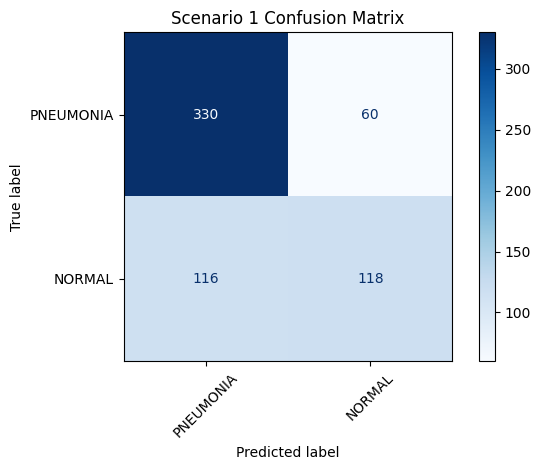

In [ ]:
# Plot the confusion matrix for scenario 1 model
scenario1_confusion_matrix = sklearn.metrics.confusion_matrix(test_labels, scenario1_predictions)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=scenario1_confusion_matrix, display_labels=POSSIBLE_LABELS)
disp.plot(cmap=plt.cm.Blues)
plt.title("Scenario 1 Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Section 2: active learning approach with N labeled elements

(we decide to label 10% of the unlabled images we have. we pick which ones to label using active learning)

In [12]:
#TODO: repeat the same stuff above BUT with an active learning 
# loop to show off much better performances

### SCENARIO 3

In this third scenario we trained the model assuming to have all the samples in the train dataset already labeled, as the original project was doing.

In [123]:
# Copy the full training dataset to be used in scenario 3
scenario3_train_features = reduced_train_features.copy()
scenario3_train_labels = train_labels.copy()

print(f"Using all the {reduced_train_features.shape[0]} available training samples for scenario 3.")
print(f"Scenario 3 training features shape: {scenario3_train_features.shape}")
print(f"Scenario 3 training labels shape: {scenario3_train_labels.shape}")

Using all the 5216 available training samples for scenario 3.
Scenario 3 training features shape: (5216, 174)
Scenario 3 training labels shape: (5216,)


In [124]:
# Train a KNN classifier on the above defined set
scenario3_classifier = sklearn.base.clone(knn_classifier)
scenario3_classifier.fit(scenario3_train_features, scenario3_train_labels)

,n_neighbors,10
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,-1


In [125]:
# Make the model calculate its predictions on the test set
scenario3_predictions = scenario3_classifier.predict(reduced_test_features)

# Print the classification report for the scenario 3 model using the test set
scenario3_report = sklearn.metrics.classification_report(test_labels, scenario3_predictions, output_dict=False, zero_division=1)
print("Scenario 3 Classification Report:\n")
print(scenario3_report)

Scenario 3 Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       390
           1       0.92      0.61      0.73       234

    accuracy                           0.83       624
   macro avg       0.86      0.79      0.81       624
weighted avg       0.85      0.83      0.82       624



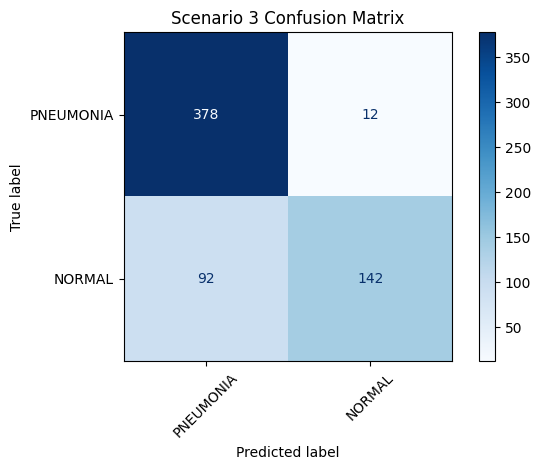

In [126]:
# Plot the confusion matrix for scenario 3 model
scenario3_confusion_matrix = sklearn.metrics.confusion_matrix(test_labels, scenario3_predictions)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=scenario3_confusion_matrix, display_labels=POSSIBLE_LABELS)
disp.plot(cmap=plt.cm.Blues)
plt.title("Scenario 3 Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()